In [1]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import seaborn as sns
import cv2
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install -r requirements.txt

In [2]:
# Let's create paths
# Loading all the images from the directory 
img_path = []
anno_path = []
dir = '/content/drive/MyDrive/ML Club NITS/Datasets/FaceMask_Dataset'
for dirname, _, filenames in os.walk(dir):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path[-3:] == 'xml':
            anno_path.append(file_path)
        else:
            img_path.append(file_path)
            
print("We load all images" if len(img_path) == 853 else "Oops...")

We load all images


In [3]:
#Creating Dataframes
df = pd.DataFrame(columns=['file_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])
#parsing the annotations
for xml_file in anno_path:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    file_name = root.find('filename').text
#   foreach object
    for obj in root.findall('object'):
        row = {
            'file_name': file_name,
            'label': obj.find('name').text,
            'xmin': int(obj.find('bndbox').find('xmin').text),
            'ymin': int(obj.find('bndbox').find('ymin').text),
            'xmax': int(obj.find('bndbox').find('xmax').text),
            'ymax': int(obj.find('bndbox').find('ymax').text)
        }
        df = df.append(row, ignore_index=True)

In [4]:
df.label.value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: label, dtype: int64

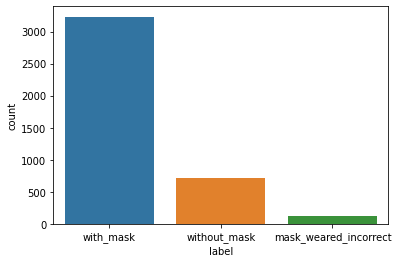

In [5]:
sns.countplot(x=df.label)

In [6]:
img_dir = '/content/drive/MyDrive/ML Club NITS/Datasets/FaceMask_Dataset/images/'
def crop_image(file, xmin, ymin, xmax, ymax, is_im_arr=False):
    if is_im_arr is False:
        im = Image.open(img_dir + file)
        im_arr = np.array(im)
    else:
        im_arr = np.array(file)
    # cropping
    im_cropped = im_arr[ymin:ymax, xmin:xmax, :3]
    return im_cropped

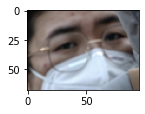

In [7]:
row = df.iloc[169]
crop_img = crop_image(row.file_name, row.xmin, row.ymin, row.xmax, row.ymax)
# plot image cropped
plt.figure(figsize=(2,2))
plt.imshow(crop_img)
plt.show()

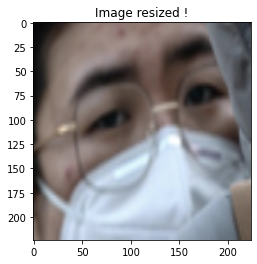

In [8]:
plt.imshow(cv2.resize(crop_img, (224, 224)))
plt.title("Image resized !")
plt.show()

In [9]:
#Creating dataset to iterate file_path to cropped images
def create_data_batch(X, y=None, batch_size=64, valid_data=False, test_data=False):

    if test_data:
        print('Creating test dataset')   #Creating the test data 
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.batch(batch_size)
    elif valid_data:
        print('Creating valid dataset')  #Creating the Validation Data
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.batch(batch_size)
    else:
        print('Creating Training dataset')  #Creating the Training Data 
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))  #Slicing the dataset 
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.batch(batch_size)
    return data_batch

In [10]:
images = []
labels = []
for i in range(len(df)):
    row = df.iloc[i]
    crop_img = crop_image(row.file_name, row.xmin, row.ymin, row.xmax, row.ymax)  #Cropping the image
    resize_img = cv2.resize(crop_img, (100, 100))  #Resizing the image into a shape of (100,100)
    resize_img = resize_img/ 255.0    #Rescaling the image 
    images.append(resize_img) 
    labels.append(row.label)
len(images), len(labels)

(4072, 4072)

In [11]:
#encoding the labels 
le = preprocessing.LabelEncoder()
labels_encoder = le.fit_transform(labels)
targets = np.array(labels_encoder)
targets.shape

(4072,)

In [12]:
#Splitting the data into TRAIN and test 
X_TRAIN, X_test, y_TRAIN, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
len(X_TRAIN)

3664

In [13]:
#Further splitting the TRAIN data data into train and validation dataset 
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, y_TRAIN, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(2931, 2931, 733, 733)

In [14]:
#Creating training data batches 
train_data = create_data_batch(X_train, y=y_train)
train_data.element_spec


Creating Training dataset


(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [15]:
#Creating Validation Data batches
val_data = create_data_batch(X_val, y=y_val, valid_data=True)
val_data.element_spec

Creating valid dataset


(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [16]:
#Creating Testing Data Batches
test_data = create_data_batch(X_test, test_data=True)

Creating test dataset


In [17]:
inputs = tf.keras.Input(shape=(100,100,3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
print(x.shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same',)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same',)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(16,activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

(None, 100, 100, 64)


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        9248      
                                                             

In [19]:
EP = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)
MCP = tf.keras.callbacks.ModelCheckpoint(
    filepath = './weights' ,
    monitor='accuracy' , 
    save_best_only=True
)

In [20]:
history_1 = model.fit(x=train_data, validation_data=val_data, epochs=10, callbacks=[EP,MCP])

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.4982 - accuracy: 0.8110

46/46 [==============================] - 14s 103ms/step - loss: 0.4982 - accuracy: 0.8110 - val_loss: 0.2298 - val_accuracy: 0.9400
Epoch 2/10
45/46 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.9292

46/46 [==============================] - 4s 82ms/step - loss: 0.2455 - accuracy: 0.9290 - val_loss: 0.1980 - val_accuracy: 0.9441
Epoch 3/10
45/46 [============================>.] - ETA: 0s - loss: 0.2056 - accuracy: 0.9326

46/46 [==============================] - 4s 79ms/step - loss: 0.2086 - accuracy: 0.9314 - val_loss: 0.1507 - val_accuracy: 0.9468
Epoch 4/10
45/46 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9358

46/46 [==============================] - 4s 80ms/step - loss: 0.2071 - accuracy: 0.9355 - val_loss: 0.1480 - val_accuracy: 0.9468
Epoch 5/10
45/46 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9375

46/46 [==============================] - 4s 78ms/step - loss: 0.1939 - accuracy: 0.9372 - val_loss: 0.1517 - val_accuracy: 0.9454
Epoch 6/10
46/46 [==============================] - 3s 56ms/step - loss: 0.1933 - accuracy: 0.9348 - val_loss: 0.1483 - val_accuracy: 0.9454
Epoch 7/10
45/46 [============================>.] - ETA: 0s - loss: 0.1758 - accuracy: 0.9403

46/46 [==============================] - 4s 82ms/step - loss: 0.1778 - accuracy: 0.9389 - val_loss: 0.1546 - val_accuracy: 0.9509
Epoch 8/10
45/46 [============================>.] - ETA: 0s - loss: 0.1606 - accuracy: 0.9438

46/46 [==============================] - 4s 78ms/step - loss: 0.1605 - accuracy: 0.9437 - val_loss: 0.1460 - val_accuracy: 0.9468
Epoch 9/10
46/46 [==============================] - 3s 58ms/step - loss: 0.1653 - accuracy: 0.9396 - val_loss: 0.1573 - val_accuracy: 0.9441
Epoch 10/10
46/46 [==============================] - 3s 58ms/step - loss: 0.1516 - accuracy: 0.9403 - val_loss: 0.1441 - val_accuracy: 0.9509
